In [7]:
import torch
import torch.nn as nn
import numpy as np
from captum.attr import IntegratedGradients
import shap

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and Integrated Gradients
model = Net()
ig = IntegratedGradients(model)

# Generate some random data
input_data = torch.randn(1, 10)

# Compute attributions using Captum
attr_captum = ig.attribute(input_data, target=0)

# Convert the model to a format that can be used with SHAP
model_func = lambda x: model(torch.from_numpy(x).float()).detach().numpy()
explainer = shap.Explainer(model_func, input_data.detach().numpy())

# Compute attributions using SHAP
shap_values = explainer(input_data.detach().numpy())

# Print the attributions
print("Attributions from Captum:")
print(attr_captum)
print("Attributions from SHAP:")
print(shap_values)

Attributions from Captum:
tensor([[-0.1305, -0.2136, -0.0028, -0.2178, -0.0207, -0.0078, -0.0662, -0.0024,
         -0.0054, -0.0476]], dtype=torch.float64)
Attributions from SHAP:
.values =
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

.base_values =
array([[-1.14150631]])

.data =
array([[-1.5489677 , -2.7913964 ,  0.47220728, -2.5364428 ,  1.6803502 ,
        -0.18429579,  1.0352919 , -0.08443964, -0.22447751, -1.1620845 ]],
      dtype=float32)


In [20]:
import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import shap

# Create a random dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Compute SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Print the average absolute SHAP values for each feature
print('Average absolute SHAP values:')
for i in range(X.shape[1]):
    print(f'Feature {i}: {(np.abs(shap_values.values[:, i]).mean()*100).round(2)} %')


F1 Score: 0.97
ROC AUC Score: 0.97
Average absolute SHAP values:
Feature 0: 24.38 %
Feature 1: 9.53 %
Feature 2: 27.95 %
Feature 3: 19.24 %
Feature 4: 14.97 %
Feature 5: 15.15 %
Feature 6: 23.09 %
Feature 7: 11.37 %
Feature 8: 17.97 %
Feature 9: 13.47 %
Feature 10: 13.04 %
Feature 11: 530.93 %
Feature 12: 166.78 %
Feature 13: 8.94 %
Feature 14: 68.69 %
Feature 15: 16.41 %
Feature 16: 16.73 %
Feature 17: 9.26 %
Feature 18: 29.1 %
Feature 19: 5.96 %


[03:07:20] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
import numpy as np
import shap

# Define a simple neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(20, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Create a random dataset
X, y = make_classification(n_samples=1000, n_features=20, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train[:, None], dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test[:, None], dtype=torch.float32)

# Create a DataLoader for the training data
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32)

# Initialize the model and the optimizer
model = Net()
optimizer = torch.optim.Adam(model.parameters())

# Train the model
for epoch in range(100):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = nn.BCELoss()(outputs, targets)
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()

with torch.no_grad():
    y_pred = (model(X_test_tensor) > 0.5).numpy()
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC Score: {roc_auc:.2f}')

# Compute SHAP values
model_func = lambda x: model(torch.from_numpy(x).float()).detach().numpy()
explainer = shap.Explainer(model_func, X_train.astype(np.float32))
shap_values = explainer(X_test.astype(np.float32))

# Print the average absolute SHAP values for each feature
print('Average absolute SHAP values:')
for i in range(X.shape[1]):
    print(f'Feature {i}: {np.abs(shap_values.values[:, i]).mean()}')

F1 Score: 0.96
ROC AUC Score: 0.96
Average absolute SHAP values:
Feature 0: 0.010126787350324377
Feature 1: 0.00334485972612686
Feature 2: 0.009921318977519801
Feature 3: 0.0048408359761426155
Feature 4: 0.0030941437604789734
Feature 5: 0.0065889535897214425
Feature 6: 0.00661511987139484
Feature 7: 0.010649368462331861
Feature 8: 0.006161366275449465
Feature 9: 0.006362920331000645
Feature 10: 0.008507944672417724
Feature 11: 0.21668996688282927
Feature 12: 0.12825890362386747
Feature 13: 0.0037486134256335454
Feature 14: 0.15904138182108757
Feature 15: 0.005763288589607947
Feature 16: 0.003190653132789797
Feature 17: 0.0016354319986581502
Feature 18: 0.0035830651865690847
Feature 19: 0.018797293179212894


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


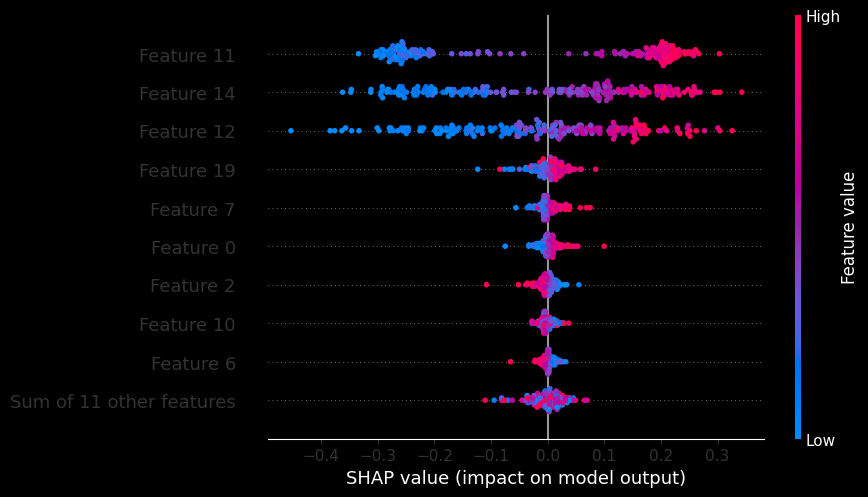

In [22]:
shap.plots.beeswarm(shap_values)